# Getting the dataset #

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/Shareddrives/DM_Project/dataset/tweets.csv /content/
!cp /content/drive/Shareddrives/DM_Project/dataset/users.csv /content/

# Importing modules #

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from matplotlib.pyplot import figure

from pandas.io.formats.style_render import DataFrame
from tqdm import tqdm

# Loading the dataset and printing information #

In [ ]:
tweets = pd.read_csv("tweets.csv")
users = pd.read_csv("users.csv")

In [ ]:
tweets.info()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664696 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   user_id         object
 2   retweet_count   object
 3   reply_count     object
 4   favorite_count  object
 5   num_hashtags    object
 6   num_urls        object
 7   num_mentions    object
 8   created_at      object
 9   text            object
dtypes: object(10)
memory usage: 1.0+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(2), object(3)


# Removing duplicates values

In [ ]:
# drops duplicates on all the columns
tweets.drop_duplicates(inplace=True, ignore_index=True)
tweets.info()

# drops duplicates on user_id, created_at and text
tweets.drop_duplicates(subset=["user_id", "created_at", "text"], inplace=True, ignore_index=True)
tweets.info()

# removes tweets which have NaN userd ID
tweets.dropna(subset=["user_id"], inplace=True)
tweets.info()

tweets = tweets.reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712597 entries, 0 to 11712596
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   user_id         object
 2   retweet_count   object
 3   reply_count     object
 4   favorite_count  object
 5   num_hashtags    object
 6   num_urls        object
 7   num_mentions    object
 8   created_at      object
 9   text            object
dtypes: object(10)
memory usage: 893.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10665159 entries, 0 to 10665158
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   user_id         object
 2   retweet_count   object
 3   reply_count     object
 4   favorite_count  object
 5   num_hashtags    object
 6   num_urls        object
 7   num_mentions    object
 8   created_at      object
 9   text            object
dtypes: object(10)
memory usage: 813.7+ MB
<class 'pand

# Eliminating tweets whose user_id is not in the user dataset
We show that there are many user IDs in the user dataset which do not have a correspondent id in the users dataset. We also show that those users produced only 210777 over more than 10 millions

In [ ]:
tweets_user_ids = tweets["user_id"].map(lambda x: str(x))
user_ids = users["id"].map(lambda x: str(x))

n1 = len(tweets_user_ids.unique())
n2 = len(user_ids.unique())
print(f"User IDs in tweets datasaet: {n1}")
print(f"IDs in users datasaet: {n2}")

s1 = set(tweets_user_ids.unique())
s2 = set(user_ids.unique())
diff = s1.difference(s2)

print(len(diff))

print(f"Users which are not in the user dataset {len(diff)}")

User IDs in tweets datasaet: 222285
IDs in users datasaet: 11508
210777
Users which are not in the user dataset 210777


In [ ]:
n = len(tweets[tweets["user_id"].isin(diff)])
print(f"Number of tweets whose users id is not in the users dataset: {n}")

Number of tweets whose users id is not in the users dataset: 217551


Removing tweets whose user ID is not in the user dataset

In [ ]:
user_ids = users["id"].to_list()
user_ids = [str(x) for x in user_ids]
tweets = tweets[tweets["user_id"].isin(user_ids)]
tweets = tweets.astype({'user_id': 'int64'})
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10230412 entries, 0 to 10447962
Data columns (total 11 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   index           int64 
 1   id              object
 2   user_id         int64 
 3   retweet_count   object
 4   reply_count     object
 5   favorite_count  object
 6   num_hashtags    object
 7   num_urls        object
 8   num_mentions    object
 9   created_at      object
 10  text            object
dtypes: int64(2), object(9)
memory usage: 936.6+ MB


# Correction of non numerical attributes#

We remove from remove from numerical columns values which are not numerical integers, by setting them to NaN

In [ ]:
numeric_cols = ['retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions']

In [ ]:
def fix_non_numeric(col):
  fixed = []
  for value in tweets[col].to_list():
    try:
      int(value)
      fixed.append(float(value))
    except ValueError:
      fixed.append(np.nan)
  return pd.Series(fixed) 


for col in numeric_cols:
  print(col)
  tweets[col] = fix_non_numeric(col)
  tweets[col].astype(np.float64, errors="raise")
  # tweets[col] = pd.to_numeric(tweets[col], errors='coerce')

tweets["retweet_count"].replace(float("inf"), np.nan, inplace=True)
tweets["reply_count"].replace(float("inf"), np.nan, inplace=True)
tweets["favorite_count"] = tweets["favorite_count"].apply(lambda x: x if x >= 0 else np.nan)

retweet_count
reply_count
favorite_count
num_hashtags
num_urls
num_mentions


# Check for float values in integer columns
We check if the numeric columns have 

In [ ]:
for col in numeric_cols:
  print(col)
  no_nan = np.ma.array(tweets[col], mask=np.isnan(tweets[col]))
  print((no_nan == no_nan.astype(int)).all())

retweet_count
True
reply_count
True
favorite_count
True
num_hashtags
True
num_urls
True
num_mentions
True


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10230412 entries, 0 to 10447962
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   index           int64  
 1   id              object 
 2   user_id         int64  
 3   retweet_count   float64
 4   reply_count     float64
 5   favorite_count  float64
 6   num_hashtags    float64
 7   num_urls        float64
 8   num_mentions    float64
 9   created_at      object 
 10  text            object 
dtypes: float64(6), int64(2), object(3)
memory usage: 936.6+ MB


# Get min and max value for every attribute #

In [ ]:
def get_min_and_max(attribute):
  print(f"{attribute.name}, min: {attribute.min()}, max: {attribute.max()}\n")

for col in numeric_cols:
  get_min_and_max(tweets[col])

retweet_count, min: 0.0, max: 229531973.0

reply_count, min: 0.0, max: 44585999.0

favorite_count, min: 0.0, max: 8955855.0

num_hashtags, min: 0.0, max: 658316.0

num_urls, min: 0.0, max: 58593401.0

num_mentions, min: 0.0, max: 501355.0



In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10230412 entries, 0 to 10447962
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   index           int64  
 1   id              object 
 2   user_id         int64  
 3   retweet_count   float64
 4   reply_count     float64
 5   favorite_count  float64
 6   num_hashtags    float64
 7   num_urls        float64
 8   num_mentions    float64
 9   created_at      object 
 10  text            object 
dtypes: float64(6), int64(2), object(3)
memory usage: 936.6+ MB


# Re-assign the IDs #
We reassign the IDs so that they are unique

In [ ]:
tweets.info()
tweets.reset_index(drop=True, inplace=True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10230412 entries, 0 to 10447962
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   index           int64  
 1   id              object 
 2   user_id         int64  
 3   retweet_count   float64
 4   reply_count     float64
 5   favorite_count  float64
 6   num_hashtags    float64
 7   num_urls        float64
 8   num_mentions    float64
 9   created_at      object 
 10  text            object 
dtypes: float64(6), int64(2), object(3)
memory usage: 936.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230412 entries, 0 to 10230411
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   index           int64  
 1   id              object 
 2   user_id         int64  
 3   retweet_count   float64
 4   reply_count     float64
 5   favorite_count  float64
 6   num_hashtags    float64
 7   num_urls        float64
 8   num_mentions    float64
 9   creat

In [ ]:
tweets["id"] = tweets.index.to_series()
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230412 entries, 0 to 10230411
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   index           int64  
 1   id              int64  
 2   user_id         int64  
 3   retweet_count   float64
 4   reply_count     float64
 5   favorite_count  float64
 6   num_hashtags    float64
 7   num_urls        float64
 8   num_mentions    float64
 9   created_at      object 
 10  text            object 
dtypes: float64(6), int64(3), object(2)
memory usage: 858.6+ MB


# Fix NaN values in text columns

In [ ]:
tweets["text"].fillna("", inplace=True)

#Fix of wrong created date
We check if the date of every tweet is between 2022-03-10 17:00:00 and the creation date of the account of the user who wrote the tweet. If it is not on that bound we set the value of the date to 2000-01-01 00:00:00

In [ ]:
correction_date = "2000-01-01 00:00:00"

user_ids = users["id"].to_list()
user_ids = [str(x) for x in user_ids]

user_dates = users["created_at"].to_list()
user_date_dict = {user_ids[i]: user_dates[i] for i in range(len(user_ids))}

account_dates = []

for user_id in tweets["user_id"].to_list():
  account_dates.append(user_date_dict[str(user_id)])

print(len(account_dates))

g = 0
l = 0

tweet_dates = tweets["created_at"].to_list()
with tqdm(total=len(account_dates)) as pbar:
  for i in range(len(account_dates)):
    if tweet_dates[i] < account_dates[i]:
      tweet_dates[i] = correction_date
      l+=1
    if tweet_dates[i] > "2022-03-10 17:00:00":
      tweet_dates[i] = correction_date
      g+=1
    pbar.update(1)

print("\n "+  str(len(tweet_dates)))
print("Number of dates too far in time: " + str(g))
print("Number of dates too far back in time: " + str(l))
print("Number of wrong dates: " + str(g+l))

tweets["created_at"] = pd.Series(tweet_dates)

tweets['created_at']= pd.to_datetime(tweets['created_at'])

10230412


100%|██████████| 10230412/10230412 [00:08<00:00, 1142177.87it/s]



 10230412
Number of dates too far in time: 48802
Number of dates too far back in time: 48803
Number of wrong dates: 97605


In [ ]:
tweets.info()

print("\n")

for col in numeric_cols:
  nans = tweets[col].isna().sum()
  print(f"{col} has {nans} NaN values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230412 entries, 0 to 10230411
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   index           int64         
 1   id              int64         
 2   user_id         int64         
 3   retweet_count   float64       
 4   reply_count     float64       
 5   favorite_count  float64       
 6   num_hashtags    float64       
 7   num_urls        float64       
 8   num_mentions    float64       
 9   created_at      datetime64[ns]
 10  text            object        
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 858.6+ MB


retweet_count has 504296 NaN values
reply_count has 1055280 NaN values
favorite_count has 1055249 NaN values
num_hashtags has 1055425 NaN values
num_urls has 1055284 NaN values
num_mentions has 765591 NaN values


# Visualize numerical attributes distribution

In [ ]:
def visualize_distribution(col):

  data = tweets[col].dropna()
  data_log = data.apply(lambda x: np.log10(x+1))

  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].set_title(f"Histogram {col} normal scale")
  ax[0].hist(data, bins=10)
  ax[1].set_title(f"Histogram {col} log scale")
  ax[1].hist(data_log, bins=10)
  plt.show()

  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].set_title(f"Histogram {col} normal scale")
  ax[0].boxplot(data)
  ax[1].set_title(f"Histogram {col} log scale")
  ax[1].boxplot(data_log)
  plt.show()


  del data
  del data_log


def mad(col):
  data = tweets[col].dropna()
  median = data.median()
  devs = []
  for val in data:
    dev = abs(val-median)
    devs.append(dev)
  return np.median(devs)


def get_stats(col):
  data = tweets[col].dropna()
  print(f"{col} statistics:")
  print(f"Mean: {data.mean()}")
  print(f"Median: {data.median()}")
  print(f"Mode: {data.mode().to_list()}")
  print(f"Standard deviation: {data.std()}")
  print(f"Median absolute deviation: {mad(col)}")
  print(f"1st quantile: {data.quantile(0.25)}")
  print(f"3rd quantile: {data.quantile(0.75)}")
  print(f"Minimum: {data.min()}")
  print(f"Maximum: {data.max()}")

retweet_count statistics:
Mean: 603.700116264293
Median: 0.0
Mode: [0.0]
Standard deviation: 75054.23978599576
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 1.0
Minimum: 0.0
Maximum: 229531973.0


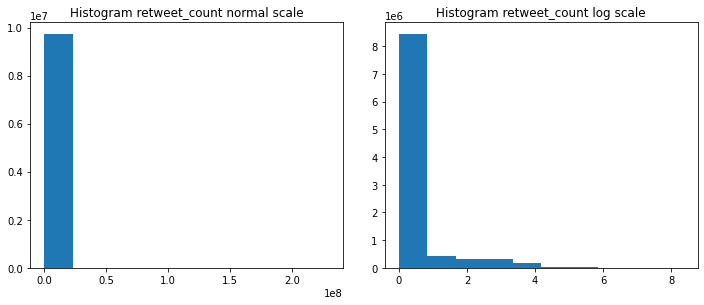

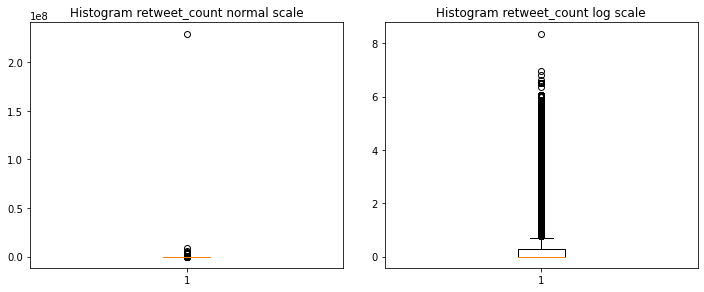




reply_count statistics:
Mean: 5.697521299966039
Median: 0.0
Mode: [0.0]
Standard deviation: 14742.799999891113
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.0
Minimum: 0.0
Maximum: 44585999.0


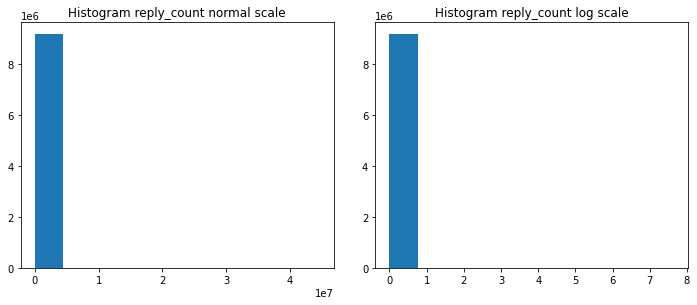

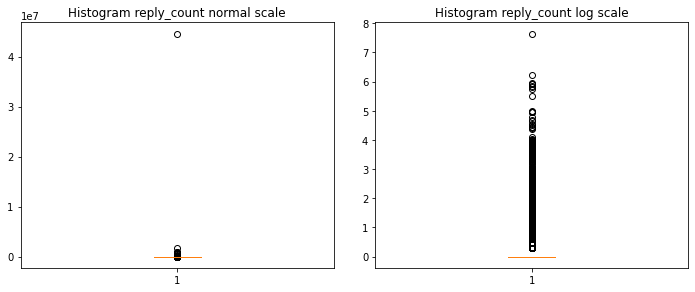




favorite_count statistics:
Mean: 3.1513401996237014
Median: 0.0
Mode: [0.0]
Standard deviation: 3002.1349374196952
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.0
Minimum: 0.0
Maximum: 8955855.0


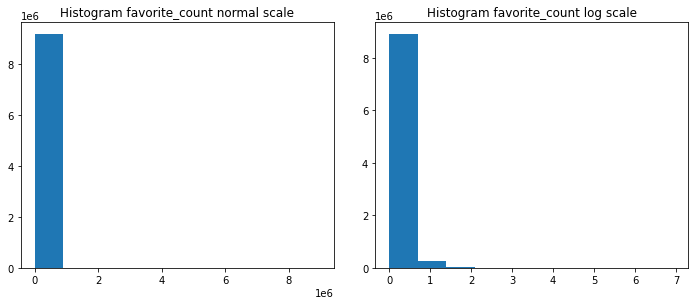

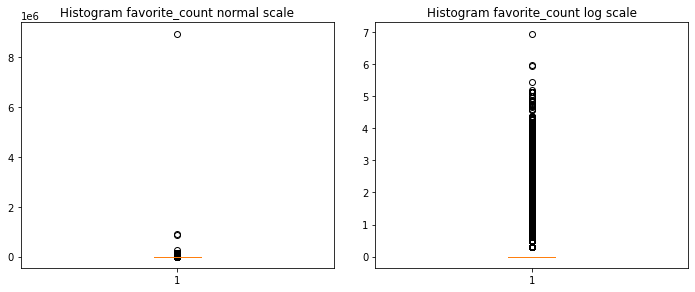




num_hashtags statistics:
Mean: 0.35349140004231067
Median: 0.0
Mode: [0.0]
Standard deviation: 265.0491122040065
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.0
Minimum: 0.0
Maximum: 658316.0


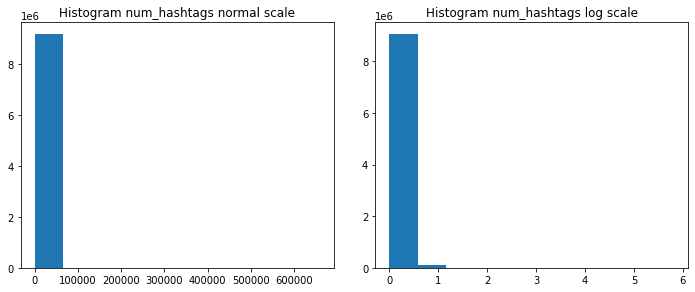

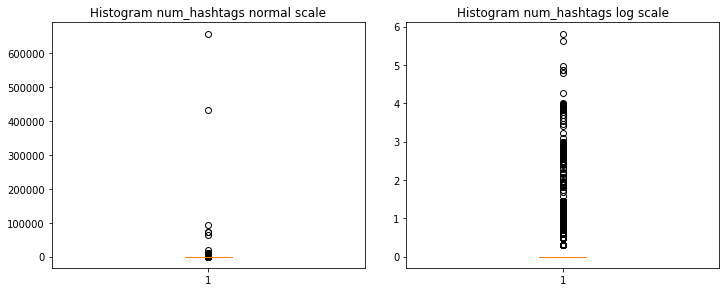




num_urls statistics:
Mean: 7.573309168002888
Median: 0.0
Mode: [0.0]
Standard deviation: 19517.839876478036
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.0
Minimum: 0.0
Maximum: 58593401.0


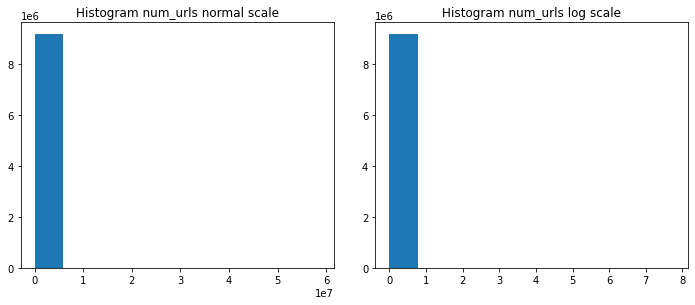

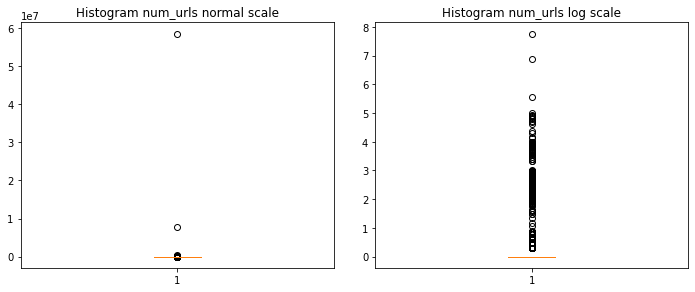




num_mentions statistics:
Mean: 0.6573329807293767
Median: 0.0
Mode: [0.0]
Standard deviation: 175.78472742255877
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 1.0
Minimum: 0.0
Maximum: 501355.0


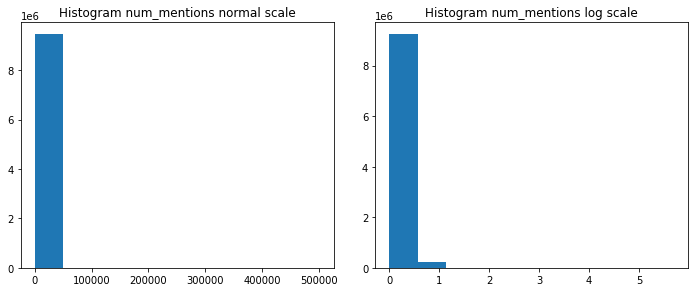

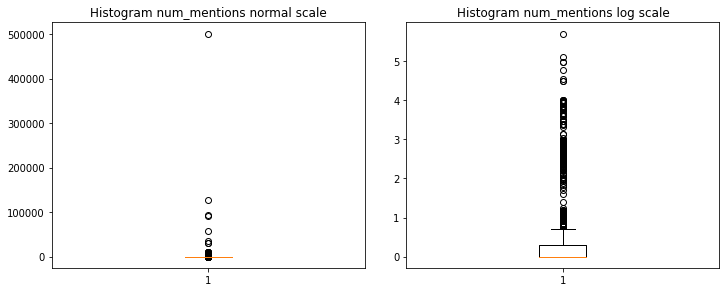

In [ ]:
for col in numeric_cols:
  get_stats(col)
  visualize_distribution(col)
  print("\n\n")

# Find the threshold for the cut
For each numerical attribute we visualize how te boxplot changes if we cut values above different orders of magnitude, and we select an appropriate order of magnitude for each attribute.

retweet_count
1000000000


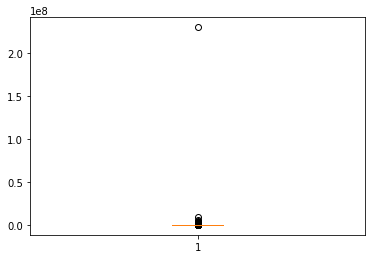

100000000


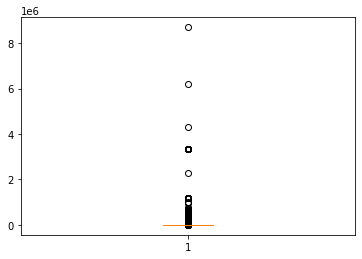

10000000


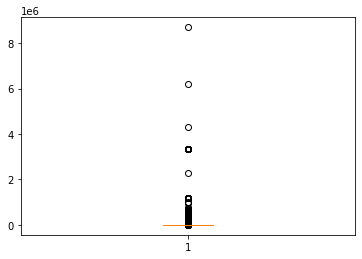

1000000


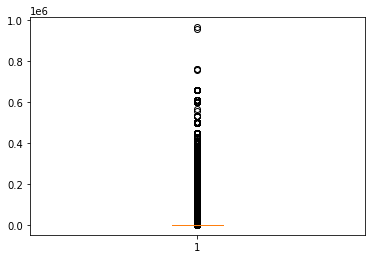

100000


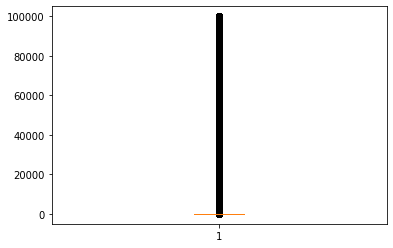

10000


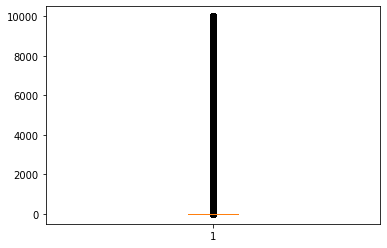

1000


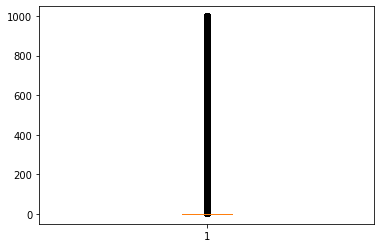

100


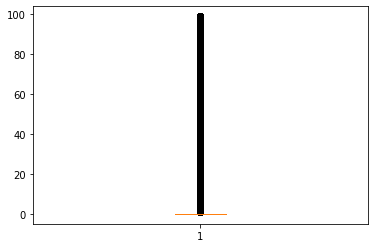

10


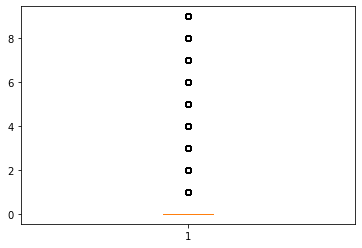





reply_count
1000000000


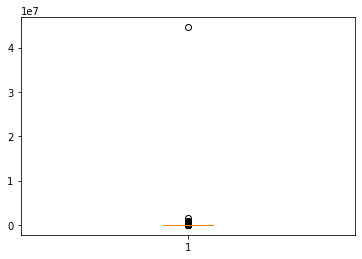

100000000


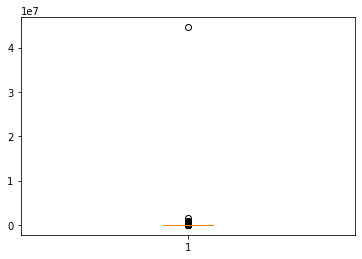

10000000


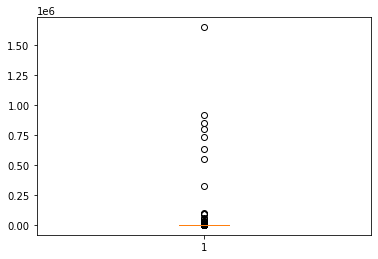

1000000


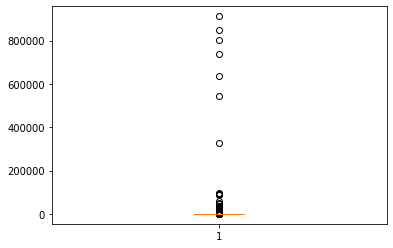

100000


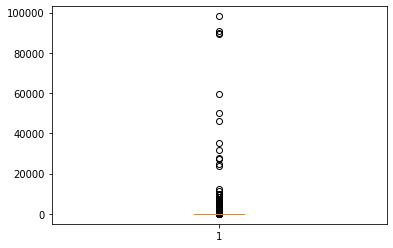

10000


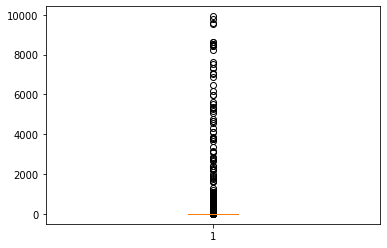

1000


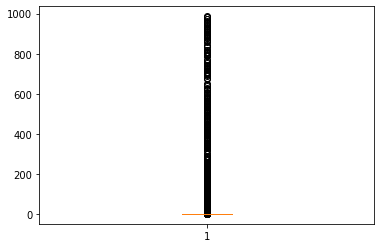

100


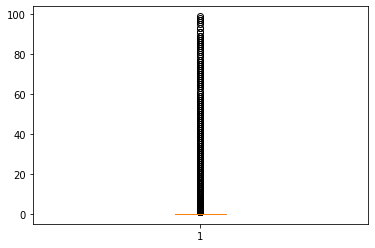

10


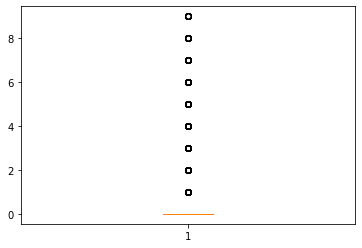





favorite_count
1000000000


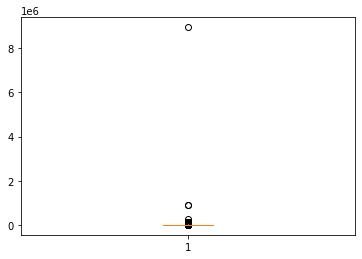

100000000


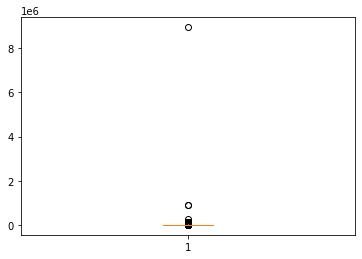

10000000


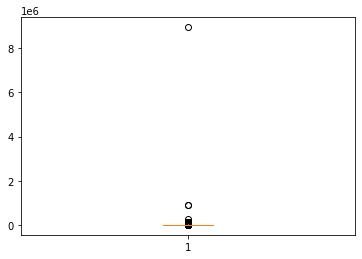

1000000


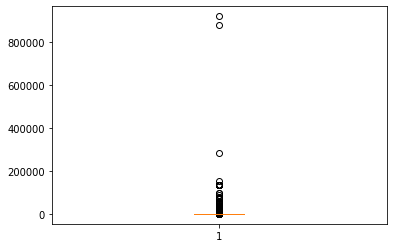

100000


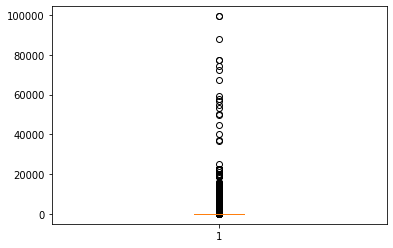

10000


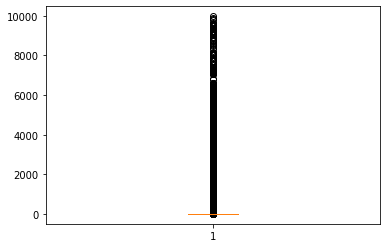

1000


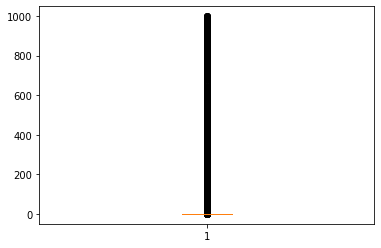

100


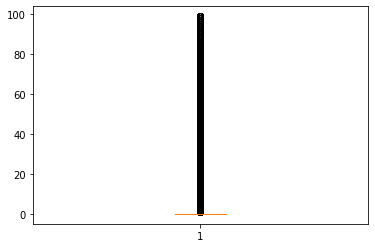

10


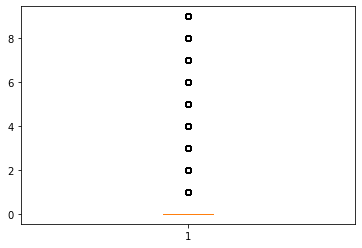





num_hashtags
1000000000


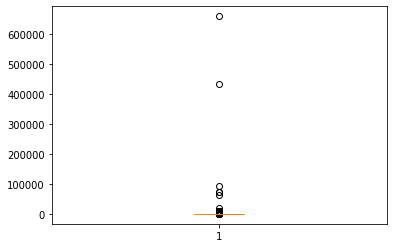

100000000


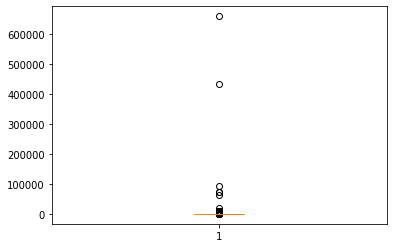

10000000


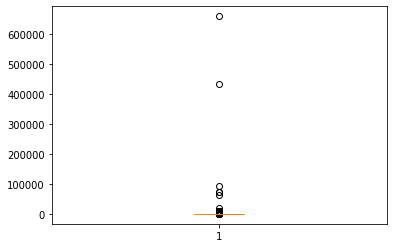

1000000


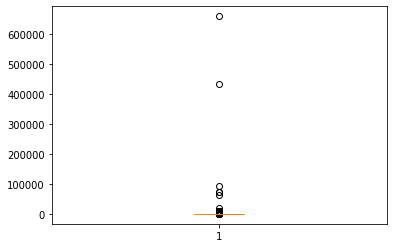

100000


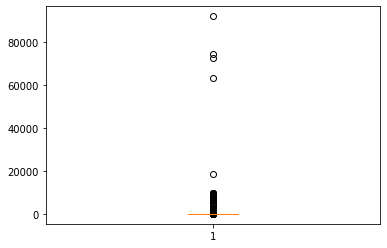

10000


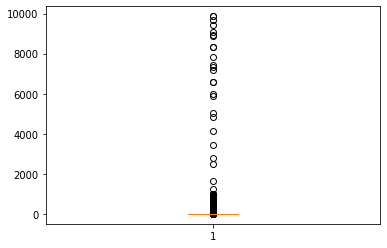

1000


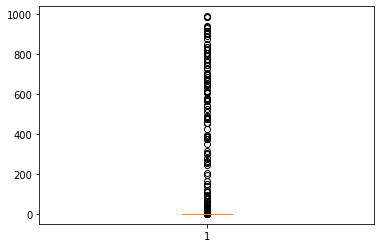

100


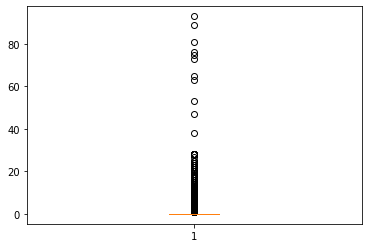

10


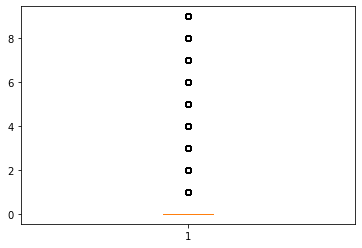





num_urls
1000000000


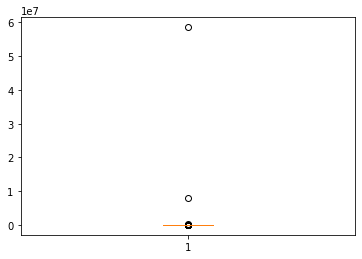

100000000


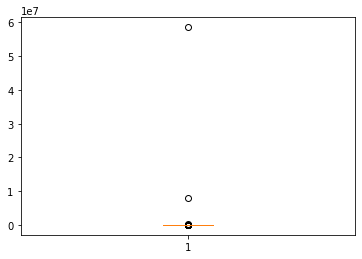

10000000


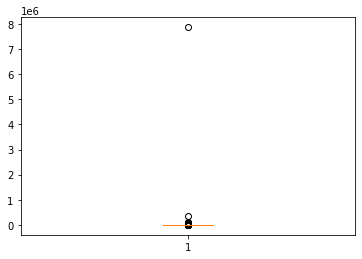

1000000


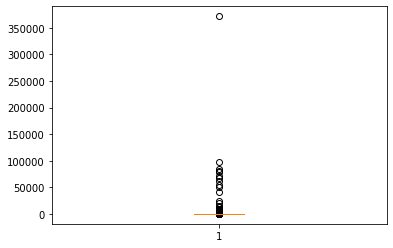

100000


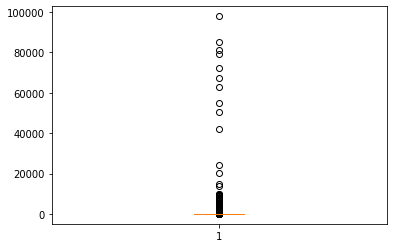

10000


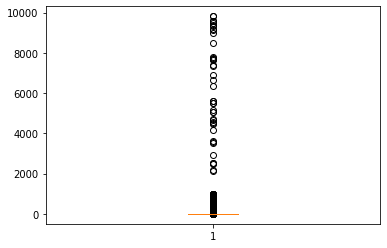

1000


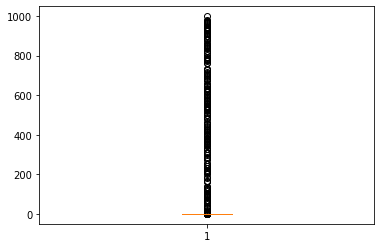

100


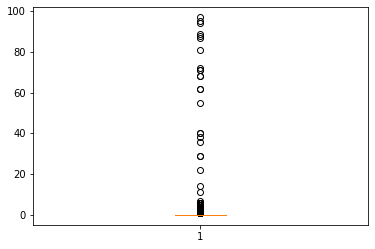

10


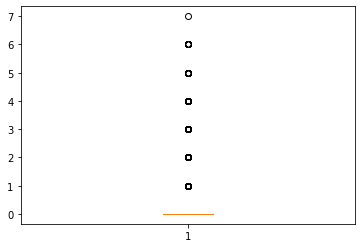





num_mentions
1000000000


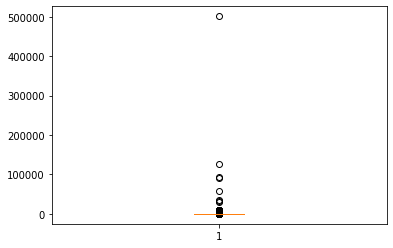

100000000


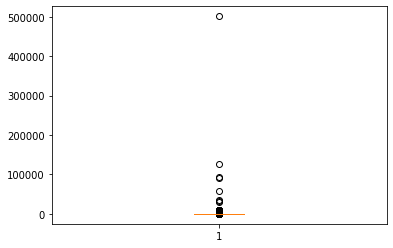

10000000


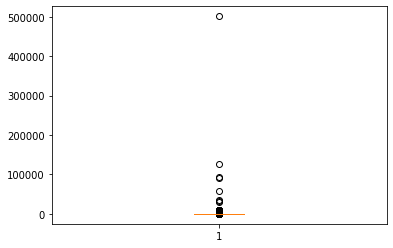

1000000


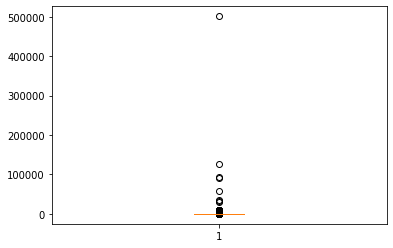

100000


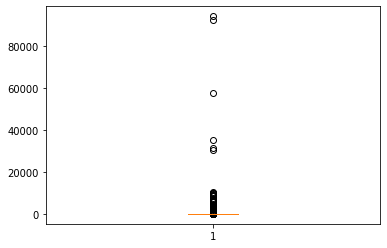

10000


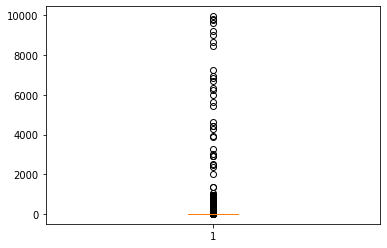

1000


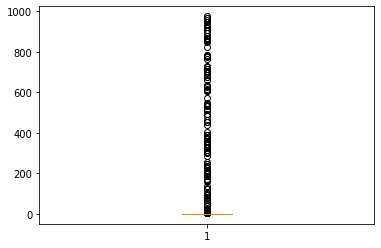

100


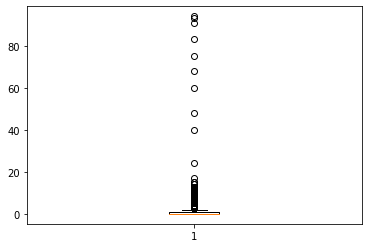

10


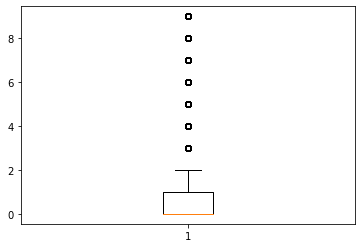

In [ ]:
for col in numeric_cols:
  print(col)
  for e in reversed(range(1,10)):
    print(10**e)
    plt.boxplot(tweets[tweets[col] <  10**e][col])
    plt.show()

  print("\n\n\n")

retweet_count


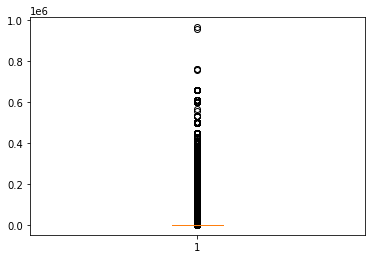




reply_count


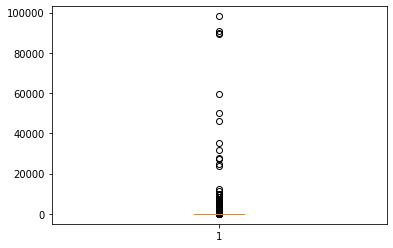




favorite_count


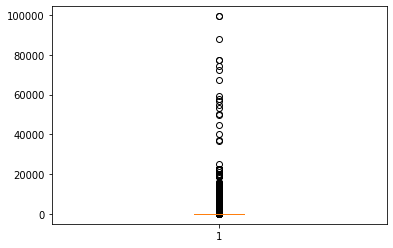




num_hashtags


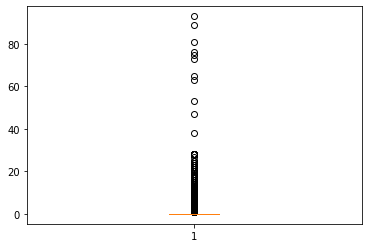




num_urls


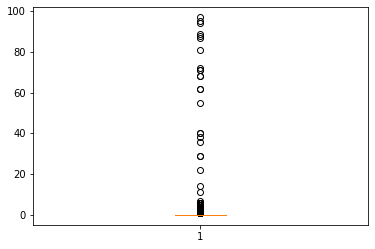




num_mentions


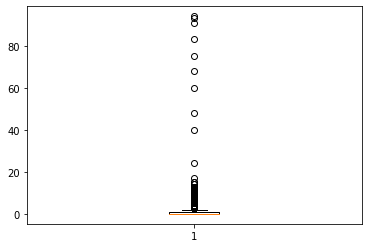

In [ ]:
cuts = {
  "retweet_count": 1000000,
  "reply_count": 100000,
  "favorite_count": 100000,
  "num_hashtags": 100,
  "num_mentions": 100,
  "num_urls": 100
}

for col in numeric_cols:
  print(col)
  cut = cuts[col]
  plt.boxplot(tweets[tweets[col] < cut][col])
  plt.show()
  print("\n\n")

# Detecting and fixing outliers
Outliers detection phase, for every attribute we study its boxplot in both normal and log scale. Since the distributions of the attributes have a really long tail, using the boxplot to remove outliers would cause to eliminate to many values. Therefore first we eliminate values above the orders of magnitude we decided before, and the we find for each attribute an appropriate threshold to cut outliers.

In [ ]:
percentiles = {
    "retweet_count": 0.999,
    "favorite_count": 0.99999,
    "reply_count": 0.9999,
    "num_mentions": 0.9999,
    "num_urls": 0.999999,
    "num_hashtags": 0.9999
}

thresholds = {}

def plot_info(col):
  cut = cuts[col]
  feature = tweets[tweets[col] < cut][col].dropna()
  feature_log = feature.apply(lambda x: np.log10(x+1))
  percentile = percentiles[col]
  # outlier = tweets_log[attr_name].quantile(percentile)
  outlier = feature.quantile(percentile)

  filtered = tweets[tweets[col] < cut][col].copy()
  filtered[filtered > outlier] = np.nan
  filtered = filtered.dropna()
  filtered_log = filtered.apply(lambda x: np.log10(x+1))

  print(f"Threshold: {outlier}")

  fig, ax = plt.subplots(1, 2, figsize=(9,3))
  fig.tight_layout()

  print("Boxplot with outliers (left normal scale, right log scale):")
  ax[0].boxplot(feature)
  ax[1].boxplot(feature_log)
  plt.show()


  fig, ax = plt.subplots(1, 2, figsize=(9,3))
  fig.tight_layout()

  print("Boxplot without outliers (left normal scale, right log scale):")
  ax[0].boxplot(filtered)
  ax[1].boxplot(filtered_log)
  plt.show()

  fig, ax = plt.subplots(1, 2, figsize=(9,3))
  fig.tight_layout()

  print("Histogram with outliers (left normal scale, right log scale):")
  ax[0].hist(feature, bins= 10)
  ax[1].hist(feature_log, bins= 10)
  plt.show()  

  fig, ax = plt.subplots(1, 2, figsize=(9,3))
  fig.tight_layout()

  print("Histogram without outliers (left normal scale, right log scale):")
  ax[0].hist(filtered, bins= 10)
  ax[1].hist(filtered_log, bins= 10)
  plt.show()

  thresholds[col] = outlier

  # tweets_log[attr_name][tweets_log[attr_name] > outlier_log] = outlier_log

  del filtered
  del filtered_log
  del feature
  del feature_log

###  Favorite count

Threshold: 10453.541437504813
Boxplot with outliers (left normal scale, right log scale):


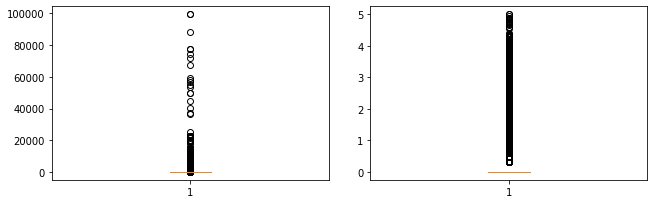

Boxplot without outliers (left normal scale, right log scale):


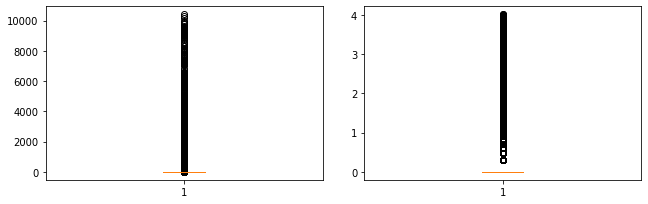

Histogram with outliers (left normal scale, right log scale):


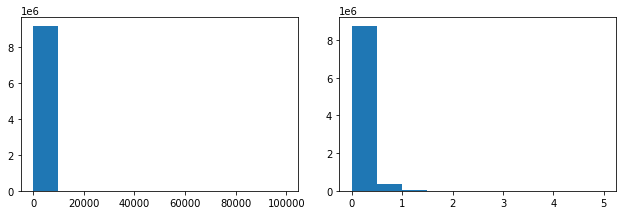

Histogram without outliers (left normal scale, right log scale):


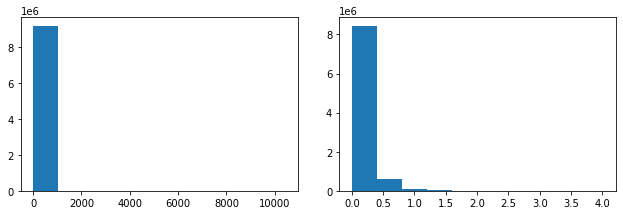

In [ ]:
# percentiles["favorite_count"] = 0.999999
# percentiles["favorite_count"] = 0.999
percentiles["favorite_count"] = 0.9999875
plot_info("favorite_count")

### Retweet count

{'whiskers': [<matplotlib.lines.Line2D at 0x7f93d359a670>,
 'caps': [<matplotlib.lines.Line2D at 0x7f93d359b220>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f93d359a880>],
 'medians': [<matplotlib.lines.Line2D at 0x7f93d359b790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f93d359bb50>],
 'means': []}

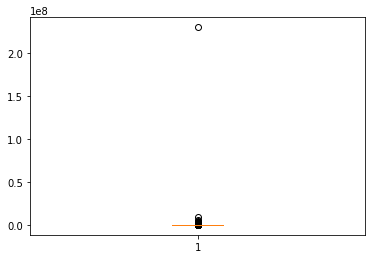

In [ ]:
plt.boxplot(tweets["retweet_count"].dropna())

Threshold: 411730.0399999991
Boxplot with outliers (left normal scale, right log scale):


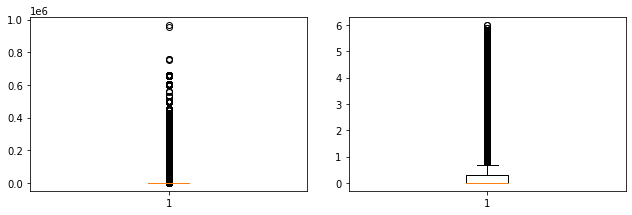

Boxplot without outliers (left normal scale, right log scale):


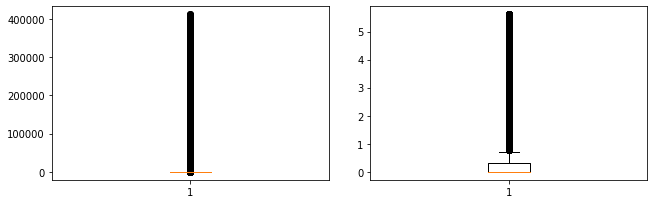

Histogram with outliers (left normal scale, right log scale):


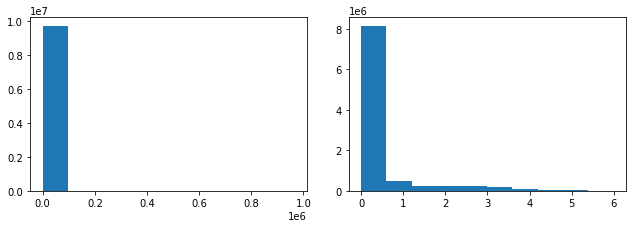

Histogram without outliers (left normal scale, right log scale):


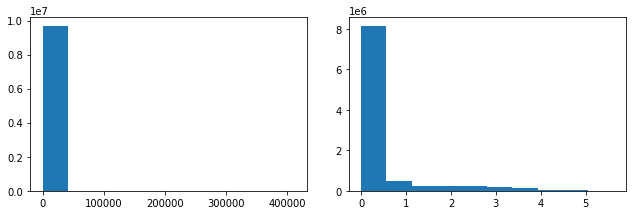

In [ ]:
# percentiles["retweet_count"] = 0.99995
# percentiles["retweet_count"] = 0.95
percentiles["retweet_count"] = 0.99995
plot_info("retweet_count")

### Reply count

Threshold: 984.7463400028646
Boxplot with outliers (left normal scale, right log scale):


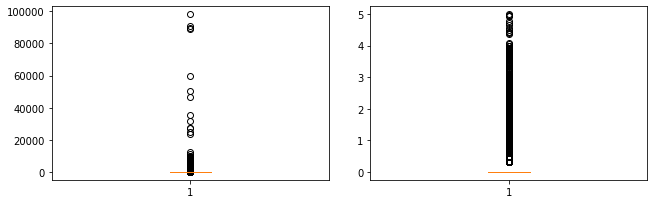

Boxplot without outliers (left normal scale, right log scale):


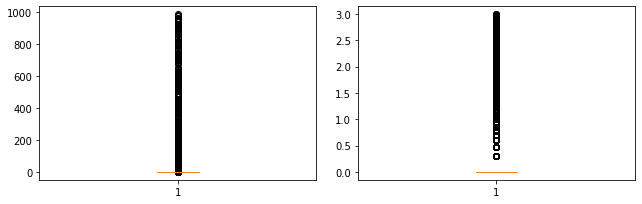

Histogram with outliers (left normal scale, right log scale):


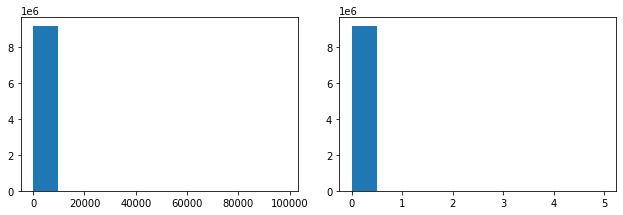

Histogram without outliers (left normal scale, right log scale):


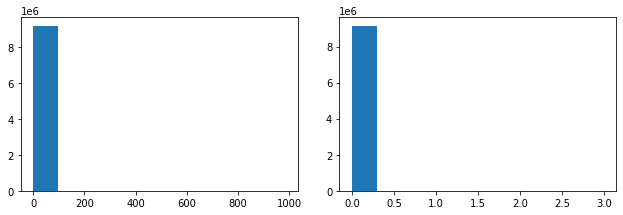

In [ ]:
# percentiles["reply_count"] = 0.999995
# percentiles["reply_count"] = 0.99995
percentiles["reply_count"] = 0.99999
plot_info("reply_count")

###  Num urls

Threshold: 9.416234195232391
Boxplot with outliers (left normal scale, right log scale):


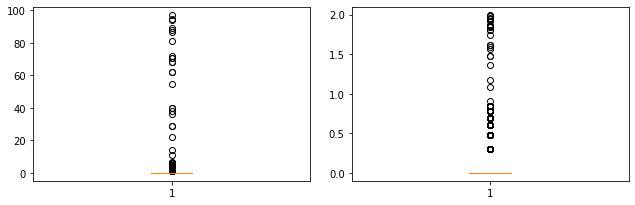

Boxplot without outliers (left normal scale, right log scale):


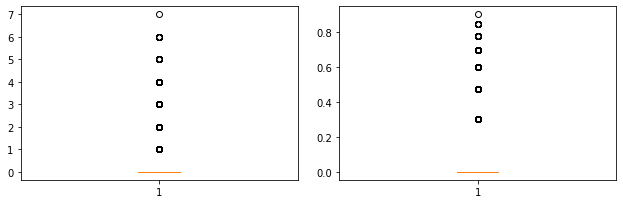

Histogram with outliers (left normal scale, right log scale):


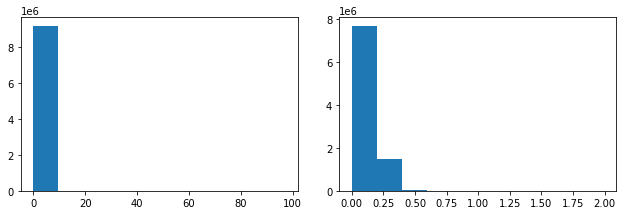

Histogram without outliers (left normal scale, right log scale):


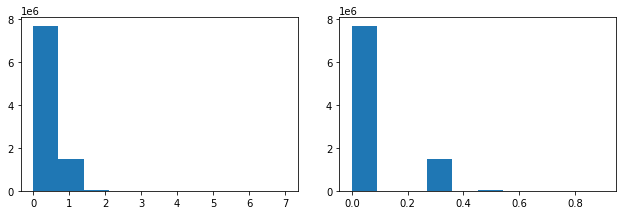

In [ ]:
# percentiles["num_urls"] = 0.99997
# percentiles["num_urls"] = 0.99997
percentiles["num_urls"] = 0.99999745
plot_info("num_urls")

###  Num mentions

Threshold: 20.747400991618633
Boxplot with outliers (left normal scale, right log scale):


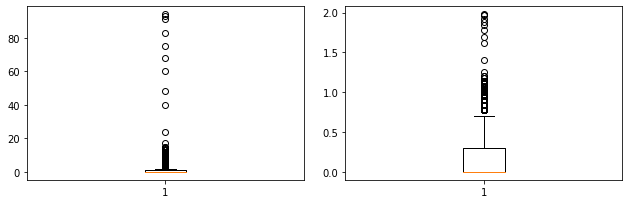

Boxplot without outliers (left normal scale, right log scale):


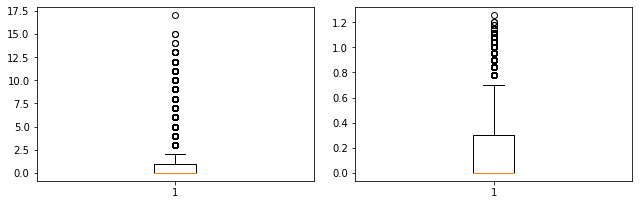

Histogram with outliers (left normal scale, right log scale):


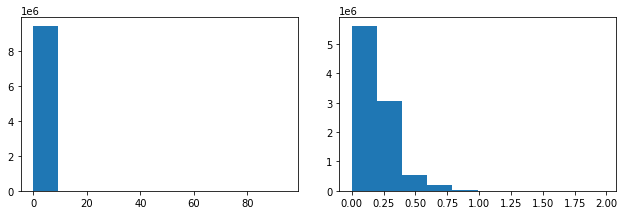

Histogram without outliers (left normal scale, right log scale):


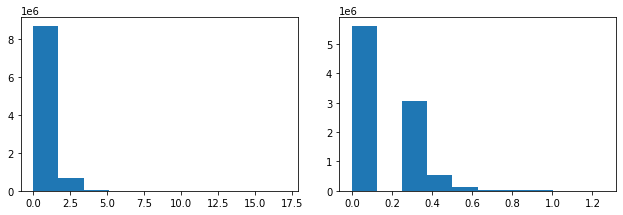

In [ ]:
# percentiles["num_mentions"] = 0.99998175
# percentiles["num_mentions"] = 0.999
percentiles["num_mentions"] = 0.999999
plot_info("num_mentions")

### Num hashtags

Threshold: 24.062834998592734
Boxplot with outliers (left normal scale, right log scale):


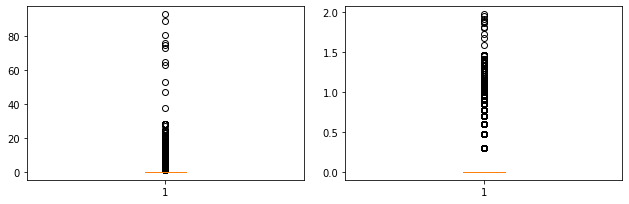

Boxplot without outliers (left normal scale, right log scale):


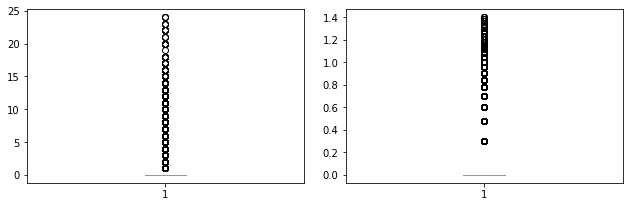

Histogram with outliers (left normal scale, right log scale):


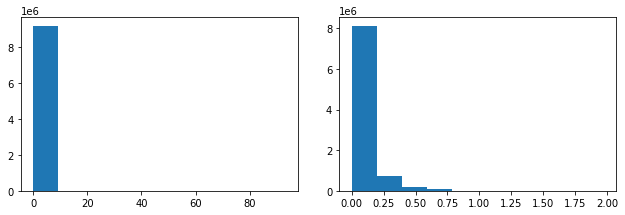

Histogram without outliers (left normal scale, right log scale):


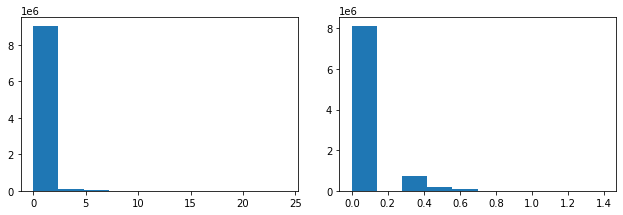

In [ ]:
# percentiles["num_hashtags"] = 0.999985
# percentiles["num_hashtags"] = 0.999
percentiles["num_hashtags"] = 0.9999975
plot_info("num_hashtags")

# Correction of NaN values
We correct all the NaN values in the numeric columns. The criterion we chose is to correct the value by replacing it with the median value of the user who wrote the tweet

In [ ]:
for col in numeric_cols:
  tweets[col][tweets[col] > thresholds[col]] = np.nan

for col in numeric_cols:
  tweets[col].fillna(tweets.groupby(["user_id"])[col].transform(np.nanmedian), inplace=True)

for col in numeric_cols:
  tweets[col].fillna(tweets[col].dropna().median(), inplace=True)
  tweets[col] = tweets[col].astype(int)


<ipython-input-34-15ee86d70681>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets[col][tweets[col] > thresholds[col]] = np.nan


In [ ]:
for col in numeric_cols:
  nans = tweets[col].isna().sum()
  print(f"{col} has {nans} NaN values")

retweet_count has 0 NaN values
reply_count has 0 NaN values
favorite_count has 0 NaN values
num_hashtags has 0 NaN values
num_urls has 0 NaN values
num_mentions has 0 NaN values


In [ ]:
for col in numeric_cols:
  get_min_and_max(tweets[col])

retweet_count, min: 0, max: 411723

reply_count, min: 0, max: 984

favorite_count, min: 0, max: 10424

num_hashtags, min: 0, max: 24

num_urls, min: 0, max: 7

num_mentions, min: 0, max: 17



# Printing stats of the numeric columns

In [ ]:
for col in numeric_cols:
  get_stats(col)
  print("\n\n")

retweet_count statistics:
Mean: 479.19695150107344
Median: 0.0
Mode: [0]
Standard deviation: 6879.4599512508385
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 1.0
Minimum: 0
Maximum: 411723



reply_count statistics:
Mean: 0.017235767239872645
Median: 0.0
Mode: [0]
Standard deviation: 2.782374001905876
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.0
Minimum: 0
Maximum: 984



favorite_count statistics:
Mean: 1.0202984004945255
Median: 0.0
Mode: [0]
Standard deviation: 49.9481395078013
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.0
Minimum: 0
Maximum: 10424



num_hashtags statistics:
Mean: 0.15819548616419357
Median: 0.0
Mode: [0]
Standard deviation: 0.5889256654786862
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.0
Minimum: 0
Maximum: 24



num_urls statistics:
Mean: 0.1475750927724123
Median: 0.0
Mode: [0]
Standard deviation: 0.3609288512116653
Median absolute deviation: 0.0
1st quantile: 0.0
3rd quantile: 0.0


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230412 entries, 0 to 10230411
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   index           int64         
 1   id              int64         
 2   user_id         int64         
 3   retweet_count   int64         
 4   reply_count     int64         
 5   favorite_count  int64         
 6   num_hashtags    int64         
 7   num_urls        int64         
 8   num_mentions    int64         
 9   created_at      datetime64[ns]
 10  text            object        
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 858.6+ MB


# Attributes correlation matrix #
We plot the attributes correlation matrix to see if we can already find correlations between the features but we show that there is no correlation. 

In [ ]:
tweets[numeric_cols].info()
corr = tweets[numeric_cols].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230412 entries, 0 to 10230411
Data columns (total 6 columns):
 #   Column          Dtype
---  ------          -----
 0   retweet_count   int64
 1   reply_count     int64
 2   favorite_count  int64
 3   num_hashtags    int64
 4   num_urls        int64
 5   num_mentions    int64
dtypes: int64(6)
memory usage: 468.3 MB


<ipython-input-39-77851b528aa5>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
retweet_count,1.00,0.00,0.01,-0.00,-0.01,0.05
reply_count,0.00,1.00,0.02,-0.00,-0.00,0.00
favorite_count,0.01,0.02,1.00,0.01,0.01,0.01
num_hashtags,-0.00,-0.00,0.01,1.00,0.09,0.09
num_urls,-0.01,-0.00,0.01,0.09,1.00,-0.04
num_mentions,0.05,0.00,0.01,0.09,-0.04,1.00


# Users dataset

#User language correction
We find that there are twos values for the language column which are not valid, and we correct them setting them to English, since it is the mode and we checked that those users wrote tweets in English 

In [ ]:
langs = users["lang"]
langs.value_counts()

en                    9970
it                     906
es                     319
pt                      65
en-gb                   50
ru                      42
fr                      36
ja                      33
zh-tw                   17
tr                      14
id                      12
ko                       9
de                       8
nl                       6
en-GB                    4
ar                       3
zh-TW                    3
da                       2
Select Language...       2
en-AU                    1
zh-cn                    1
pl                       1
el                       1
fil                      1
sv                       1
xx-lc                    1
Name: lang, dtype: int64

In [ ]:
users[(users["lang"] == "Select Language...") | (users["lang"] == "xx-lc")]

,id,name,lang,bot,created_at,statuses_count
4166,2956613720,Leanne Arker,Select Language...,0,2020-01-05 00:09:59,57.0
8666,2904858613,Brooke,Select Language...,0,2019-11-22 05:44:46,85.0
10065,29552151,Chloe,xx-lc,0,2014-04-09 21:36:02,15398.0


In [ ]:
tweets[tweets["user_id"] == 2956613720]["text"].head(10) # writes in english

197666     @bernardchickey I've heard of something called...
557598     RT @stephenfry: If physical diseases were trea...
694765     @Hilary_Barry Gives new meaning to the term sl...
787441                                                      
831404     RT @philipreeve: Help. If you c medal tweet me...
940087     RT @rodemmerson: ... If Only ...  my cartoon i...
1027393    @bernardchickey @radionz  True enough; it's in...
1060039    Sell soap for health, says Valerie Adams  And ...
1272227    @janepatterson I'm with you there Jane. I thin...
1322408    RT @Channel4News: Britain's health service: th...
Name: text, dtype: object

In [ ]:
tweets[tweets["user_id"] == 2904858613]["text"].head(10) # writes in english

49978                            @GinnyBlackmore fucking sad
452669     @NataliaKills had the right to an opinion mean...
1150515               @NataliaKills omg please be new music 
1350883    @NataliaKills @Madonna When 2 queens write a s...
1573045    On my fb newsfeed unfriending &amp; unliking a...
1614725    literally hate New Zealand tv all a bunch off ...
1697586       RT @NataliaKills: Just another Saturday Night 
1765737               When @NataliaKills posts your drawing 
1825734                           Fuck yes just got Netflix 
1844092    This sums me up when I try to play cute in fro...
Name: text, dtype: object

In [ ]:
tweets[tweets["user_id"] == 29552151]["text"].head(10) # writes in english

5902     Spent the majority of my day drawing around, c...
11781      We all love dem cuddles. http://t.co/fPrcnUfacS
15380                 Dog sitting until 8 tonight. Again..
16354                                                     
16845              The chocolate is soooooooooooo amazing.
22324    Just trying to print this goddamn cover letter...
24507                        Itchy tattoo...arrrrrrrggghh.
39434    Watching Lip Sync Battle on TV with The Rock, ...
40108    Painting my nails a perdy purple. http://t.co/...
45508                      Sweeeet. http://t.co/0BZu8abIFS
Name: text, dtype: object

In [ ]:
strange_languages = users[(users['lang'] == "Select Language...")  | (users['lang'] == "xx-lc") ]
users["lang"].replace("Select Language...", 'en', inplace=True)
users["lang"].replace("xx-lc", 'en', inplace=True)

In [ ]:
langs = users["lang"]
langs.value_counts()

en       9973
it        906
es        319
pt         65
en-gb      50
ru         42
fr         36
ja         33
zh-tw      17
tr         14
id         12
ko          9
de          8
nl          6
en-GB       4
ar          3
zh-TW       3
da          2
en-AU       1
zh-cn       1
pl          1
el          1
fil         1
sv          1
Name: lang, dtype: int64

We inglobe all the various types of English and Chinese to simply en and zh

In [ ]:
users["lang"].replace("en-GB", "en", inplace=True)
users["lang"].replace("en-gb", "en", inplace=True)
users["lang"].replace("en-AU", "en", inplace=True)
users["lang"].replace("zh-TW", "zh", inplace=True)
users["lang"].replace("zh-tw", "zh", inplace=True)
users["lang"].replace("zh-cn", "zh", inplace=True)


langs = users["lang"]
langs.value_counts()

en     10028
it       906
es       319
pt        65
ru        42
fr        36
ja        33
zh        21
tr        14
id        12
ko         9
de         8
nl         6
ar         3
da         2
pl         1
el         1
fil        1
sv         1
Name: lang, dtype: int64

# Languages distribution
We show the language distribution, first considering all the users, then considering only the real users and then only the bot users

All users


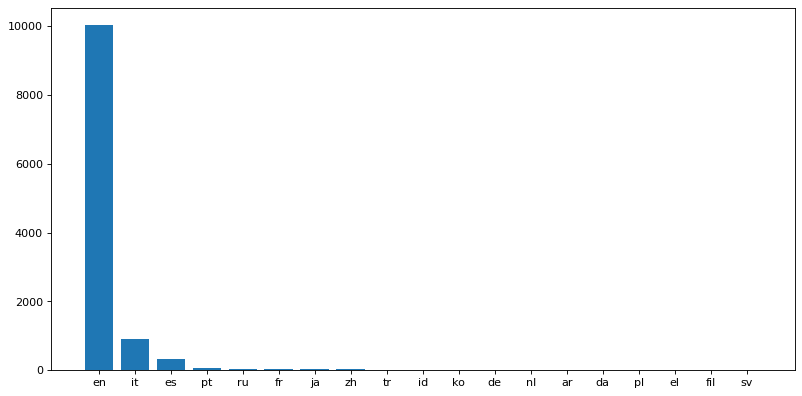

Real users


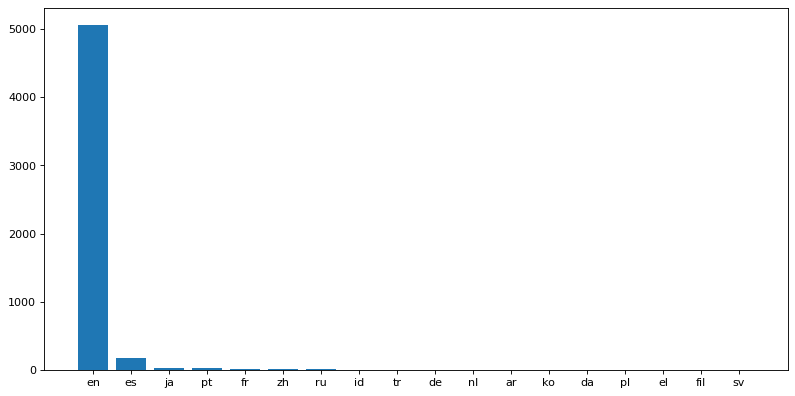

Bot users


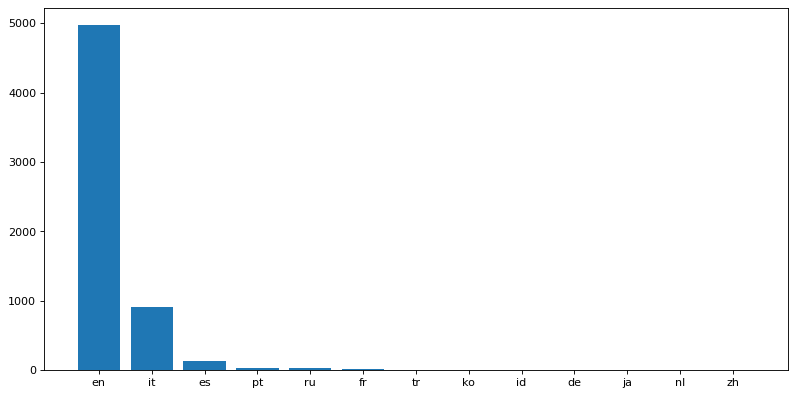

In [ ]:
print("All users")
langs_dict = langs.value_counts().to_dict()
figure(figsize=(12, 6), dpi=80)
plt.bar(langs_dict.keys(), langs_dict.values())
plt.show()

print("Real users")
langs_dict = users[users["bot"] == 0]["lang"].value_counts().to_dict()
figure(figsize=(12, 6), dpi=80)
plt.bar(langs_dict.keys(), langs_dict.values())
plt.show()

print("Bot users")
langs_dict = users[users["bot"] == 1]["lang"].value_counts().to_dict()
figure(figsize=(12, 6), dpi=80)
plt.bar(langs_dict.keys(), langs_dict.values())
plt.show()

# Check bots values # 

In [ ]:
print(users["bot"].unique())
users["bot"].value_counts()

[1 0]


1    6116
0    5392
Name: bot, dtype: int64

# Check statuses 
Since the type of statuses count is float we check if among the non NaN values there are real values. The result is that we only have integer values

In [ ]:
# users["statuses_count"].fillna(users["statuses_count"].median(), inplace=True)
integers = 0
for count in users["statuses_count"]:
  if str(count) != "nan":
    if count.is_integer():
      integers += 1

print(integers)

11109


# Statuses count distribution
We show the distribution of the statuses count attribute, first for all the users then for real users only and then for bot users only. We show the distribution in both normal and logarithmic scale

Statuses count:


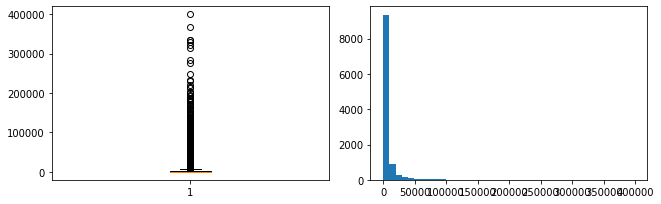

Real statuses count:


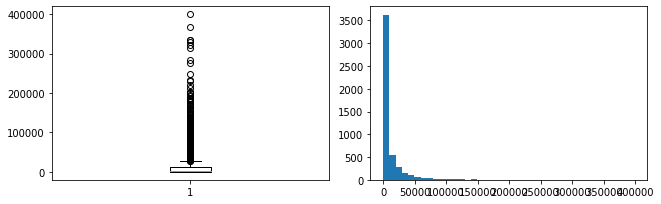

Bot statuses count:


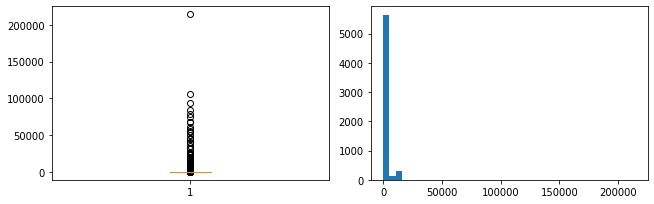

Statuses count log:


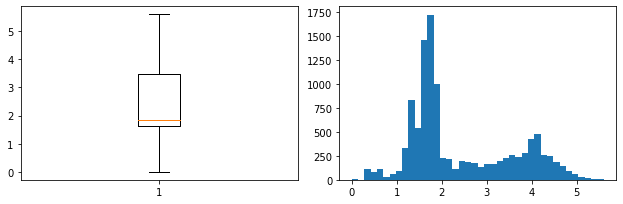

Real statuses count log:


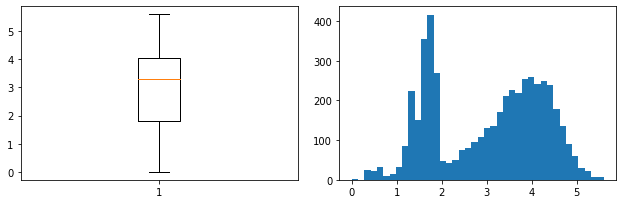

Bot statuses count log:


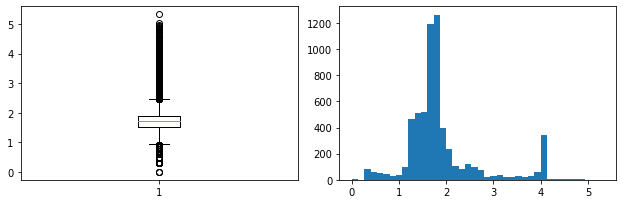

In [ ]:
statuses = users["statuses_count"].dropna()#.apply(lambda x: np.log10(x+1))


print("Statuses count:")
fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.tight_layout()

ax[0].boxplot(statuses)
ax[1].hist(statuses, bins=40)
plt.show()

print("Real statuses count:")
statuses = users[users["bot"] == 0]["statuses_count"].dropna()#.apply(lambda x: np.log10(x+1))
fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.tight_layout()
ax[0].boxplot(statuses)
ax[1].hist(statuses, bins=40)
plt.show()


print("Bot statuses count:")
statuses = users[users["bot"] == 1]["statuses_count"].dropna()# .apply(lambda x: np.log10(x+1))
fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.tight_layout()
ax[0].boxplot(statuses)
ax[1].hist(statuses, bins=40)
plt.show()


statuses = users["statuses_count"].dropna().apply(lambda x: np.log10(x+1))

print("Statuses count log:")
fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.tight_layout()

ax[0].boxplot(statuses)
ax[1].hist(statuses, bins=40)
plt.show()

print("Real statuses count log:")
statuses = users[users["bot"] == 0]["statuses_count"].dropna().apply(lambda x: np.log10(x+1))
fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.tight_layout()
ax[0].boxplot(statuses)
ax[1].hist(statuses, bins=40)
plt.show()


print("Bot statuses count log:")
statuses = users[users["bot"] == 1]["statuses_count"].dropna().apply(lambda x: np.log10(x+1))
fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.tight_layout()
ax[0].boxplot(statuses)
ax[1].hist(statuses, bins=40)
plt.show()

In [ ]:
def mad(data):
  median = data.median()
  devs = []
  for val in data:
    dev = abs(val-median)
    devs.append(dev)
  return np.median(devs)


def get_stats(data):
  print(f"Mean: {data.mean()}")
  print(f"Median: {data.median()}")
  print(f"Mode: {data.mode().to_list()}")
  print(f"Standard deviation: {data.std()}")
  print(f"Median absolute deviation: {mad(data)}")
  print(f"1st quantile: {data.quantile(0.25)}")
  print(f"3rd quantile: {data.quantile(0.75)}")
  print(f"Minimum: {data.min()}")
  print(f"Maximum: {data.max()}")

print("All users statuses count")
get_stats(users["statuses_count"].dropna())
print("\n\n")

print("Real users statuses count")
get_stats(users[users["bot"] == 0]["statuses_count"].dropna())
print("\n\n")

print("Bot users statuses count")
get_stats(users[users["bot"] == 1]["statuses_count"].dropna())

All users statuses count
Mean: 5883.312359348276
Median: 68.0
Mode: [43.0]
Standard deviation: 19073.00730458649
Median absolute deviation: 49.0
1st quantile: 41.0
3rd quantile: 2916.0
Minimum: 0.0
Maximum: 399555.0



Real users statuses count
Mean: 11638.21910674945
Median: 2041.0
Mode: [43.0]
Standard deviation: 26719.438432180214
Median absolute deviation: 2016.0
1st quantile: 61.0
3rd quantile: 11585.0
Minimum: 0.0
Maximum: 399555.0



Bot users statuses count
Mean: 1185.1028449967298
Median: 53.0
Mode: [44.0]
Standard deviation: 5373.5506300358375
Median absolute deviation: 23.0
1st quantile: 32.0
3rd quantile: 78.0
Minimum: 0.0
Maximum: 214410.0


# Outlier detection for bot statuses count ouliers
The log boxplot of statuses count for the real users does not detect any outliers, while the log boxplot for bot users detects many outliers, therefore we apply outliers detection only for bot users case

In [ ]:
bots_log = users[users["bot"] == 1]["statuses_count"].apply(lambda x: np.log10(x+1))
print("Bot users log statistics")
get_stats(bots_log.dropna())
upp_bound = bots_log.mean() + 2*bots_log.std()
low_bound = bots_log.mean() - 2*bots_log.std()
bots_log_mask = (bots_log > upp_bound) | (bots_log < low_bound)

Bot users log statistics
Mean: 1.8876284197232411
Median: 1.7323937598229686
Mode: [1.6532125137753437]
Standard deviation: 0.7913562280745003
Median absolute deviation: 0.18832571547269294
1st quantile: 1.5185139398778875
3rd quantile: 1.8976270912904414
Minimum: 0.0
Maximum: 5.331247062348879


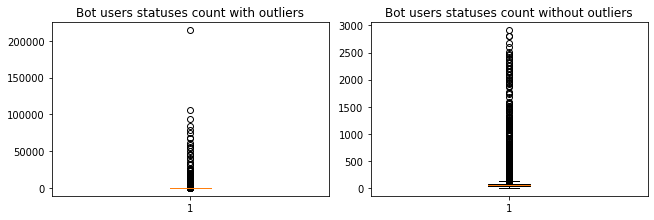

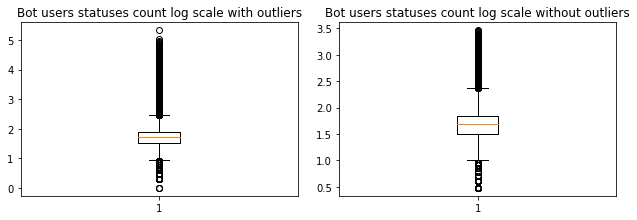

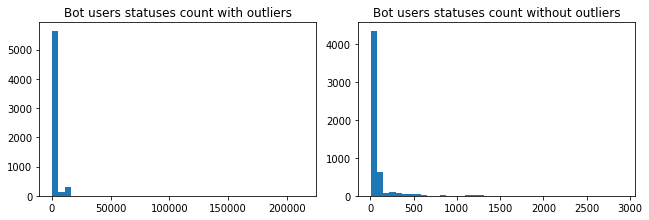

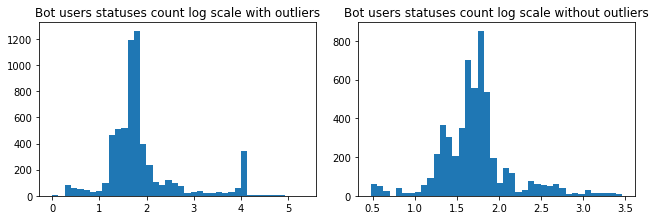

In [ ]:
statuses = users[users["bot"] == 1]["statuses_count"]
statuses_corr = statuses[~bots_log_mask]
statuses = statuses.dropna()
statuses_corr = statuses_corr.dropna()
statuses_log = statuses.apply(lambda x: np.log10(x+1))
statuses_corr_log = statuses_corr.apply(lambda x: np.log10(x+1))

fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.tight_layout()
ax[0].boxplot(statuses)
ax[0].set_title("Bot users statuses count with outliers")
ax[1].boxplot(statuses_corr)
ax[1].set_title("Bot users statuses count without outliers")
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.tight_layout()
ax[0].boxplot(statuses_log)
ax[0].set_title("Bot users statuses count log scale with outliers")
ax[1].boxplot(statuses_corr_log)
ax[1].set_title("Bot users statuses count log scale without outliers")
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.tight_layout()
ax[0].hist(statuses, bins=40)
ax[0].set_title("Bot users statuses count with outliers")
ax[1].hist(statuses_corr, bins=40)
ax[1].set_title("Bot users statuses count without outliers")
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.tight_layout()
ax[0].hist(statuses_log, bins=40)
ax[0].set_title("Bot users statuses count log scale with outliers")
ax[1].hist(statuses_corr_log, bins=40)
ax[1].set_title("Bot users statuses count log scale without outliers")
plt.show()

In [ ]:
index = bots_log_mask[bots_log_mask == True].index
users.loc[index, "statuses_count"] = np.nan

In [ ]:
print("Bot users statuses count")
get_stats(users[users["bot"] == 1]["statuses_count"].dropna())

Bot users statuses count
Mean: 101.70705604933792
Median: 48.0
Mode: [44.0]
Standard deviation: 236.15597240955483
Median absolute deviation: 20.0
1st quantile: 30.0
3rd quantile: 69.0
Minimum: 2.0
Maximum: 2911.0


# Fixing statuses count missing values
We correct statuses count NaN values by setting them to the median value of the attribute 

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  10506 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 539.6+ KB


In [ ]:
# users["statuses_count"].fillna(users["statuses_count"].median(), inplace=True)
real_median = users[users["bot"] == 0]["statuses_count"].median()
bot_median = users[users["bot"] == 1]["statuses_count"].median()

mask_real = users[users["bot"] == 0]["statuses_count"].isna()
mask_bot = users[users["bot"] == 1]["statuses_count"].isna()

nan_ids = users[users["bot"] == 0].loc[mask_real.to_list()].index.to_list()
users.loc[nan_ids, "statuses_count"] = users.loc[nan_ids, "statuses_count"].fillna(real_median)

nan_ids = users[users["bot"] == 1].loc[mask_bot.to_list()].index.to_list()
users.loc[nan_ids, "statuses_count"] = users.loc[nan_ids, "statuses_count"].fillna(bot_median)

users["statuses_count"] = users["statuses_count"].astype(int)

print(real_median, bot_median)

2041.0 48.0


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              11508 non-null  int64 
 1   name            11507 non-null  object
 2   lang            11508 non-null  object
 3   bot             11508 non-null  int64 
 4   created_at      11508 non-null  object
 5   statuses_count  11508 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 539.6+ KB


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              11508 non-null  int64 
 1   name            11507 non-null  object
 2   lang            11508 non-null  object
 3   bot             11508 non-null  int64 
 4   created_at      11508 non-null  object
 5   statuses_count  11508 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 539.6+ KB


# Fix missing name #

In [ ]:
print("Pre fix:")
print(users[users["name"].isnull()])
# users[["name"]].loc[1535] = "name"
null_ids = users[users["name"].isnull()].index.tolist()
users.loc[null_ids, "name"] = "name"

print("\nAfter fix:")
print(users[users["name"].isnull()])

Pre fix:
              id name lang  bot           created_at  statuses_count
1535  2166124159  NaN   en    0  2018-11-02 06:39:14            6566

After fix:
Empty DataFrame
Columns: [id, name, lang, bot, created_at, statuses_count]
Index: []


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              11508 non-null  int64 
 1   name            11508 non-null  object
 2   lang            11508 non-null  object
 3   bot             11508 non-null  int64 
 4   created_at      11508 non-null  object
 5   statuses_count  11508 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 539.6+ KB


### Bot vs real users

{1: 6116, 0: 5392}


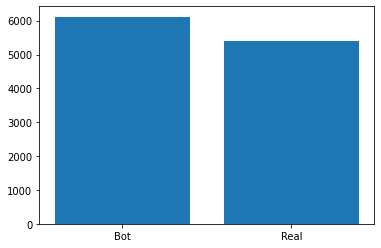

In [ ]:
bot = users["bot"].value_counts().to_dict()
print(bot)
plt.bar(["Bot", "Real"], bot.values())
plt.show()

# Statuses count of bot vs real users #

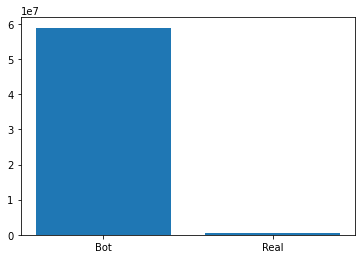

In [ ]:
statuses = users[["bot", "statuses_count"]].groupby("bot").sum().to_dict()["statuses_count"]
plt.bar(["Bot", "Real"], statuses.values())
plt.show()

# Check account creation dates 
We show the minimum and maximum account creation date, to check if they are within a valid range. The result is that they are in a valid range

In [ ]:
users["created_at"] = pd.to_datetime(users["created_at"])

users.info()

min_date = users["created_at"].min()
max_date = users["created_at"].max()

print(f"\nMinimum account creation date: {min_date}")
print(f"Maximum account creation date: {max_date}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              11508 non-null  int64         
 1   name            11508 non-null  object        
 2   lang            11508 non-null  object        
 3   bot             11508 non-null  int64         
 4   created_at      11508 non-null  datetime64[ns]
 5   statuses_count  11508 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 539.6+ KB

Minimum account creation date: 2012-01-24 01:57:38
Maximum account creation date: 2020-04-21 07:28:31


# Plot creation dates distirbutions
We show how many accounts have been created each year, first considering all the users, then considering only real users, then considering only bot users

All users


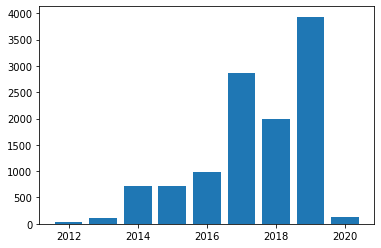


Real users


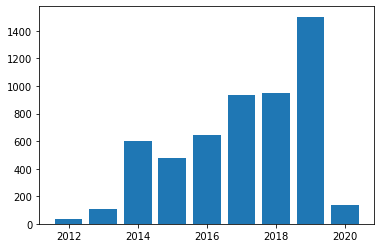


Bot users


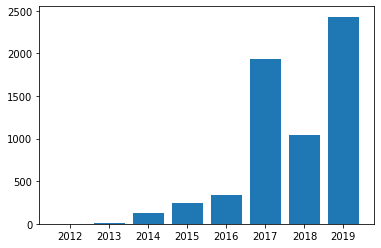

In [ ]:
print("All users")
accounts = users[["created_at"]].groupby(users["created_at"].dt.year).count().to_dict()["created_at"]
plt.bar(accounts.keys(), accounts.values())
plt.show()

print("\nReal users")
accounts = users[users["bot"] == 0][["created_at"]].groupby(users["created_at"].dt.year).count().to_dict()["created_at"]
plt.bar(accounts.keys(), accounts.values())
plt.show()


print("\nBot users")
accounts = users[users["bot"] == 1][["created_at"]].groupby(users["created_at"].dt.year).count().to_dict()["created_at"]
plt.bar(accounts.keys(), accounts.values())
plt.show()


# Merge the two datasets #

In [ ]:
users.rename(columns={"id": "user_id"}, inplace=True)
users['created_at']= pd.to_datetime(users['created_at'])
tweets_users = users.merge(tweets, on="user_id", how="inner")
tweets_users.rename(columns={"created_at_x": "user_timestamp", "created_at_y": "tweet_timestamp"}, inplace=True)
tweets_users.info()
users.rename(columns={"user_id": "id"}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10230412 entries, 0 to 10230411
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   user_id          int64         
 1   name             object        
 2   lang             object        
 3   bot              int64         
 4   user_timestamp   datetime64[ns]
 5   statuses_count   int64         
 6   index            int64         
 7   id               int64         
 8   retweet_count    int64         
 9   reply_count      int64         
 10  favorite_count   int64         
 11  num_hashtags     int64         
 12  num_urls         int64         
 13  num_mentions     int64         
 14  tweet_timestamp  datetime64[ns]
 15  text             object        
dtypes: datetime64[ns](2), int64(11), object(3)
memory usage: 1.3+ GB


In [ ]:
%cd "/content/drive/Shareddrives/DM_Project/dataset"
tweets_users.to_csv("tweets_users.csv", index=False)
users.to_csv("users_clean.csv", index=False)

/content/drive/Shareddrives/DM_Project/dataset


# Showing tweets numeric attributes distributions conditionend on real and bot users

In [ ]:
def show_distributions(col):

  real_values = tweets_users[tweets_users["bot"] == 0][col]
  log_real_values = real_values.apply(lambda x: np.log10(x+1))

  bot_values = tweets_users[tweets_users["bot"] == 1][col]
  log_bot_values = bot_values.apply(lambda x: np.log10(x+1))

  print("Real users distribution (normal scale)")
  fig, ax = plt.subplots(1, 2, figsize=(9,3))
  fig.tight_layout()
  ax[0].boxplot(real_values)
  ax[1].hist(real_values, bins=10)
  plt.show()

  print("Bot users distribution (normal scale)")
  fig, ax = plt.subplots(1, 2, figsize=(9,3))
  fig.tight_layout()
  ax[0].boxplot(bot_values)
  ax[1].hist(bot_values, bins=10)
  plt.show()

  print("Real users distribution (log scale)")
  fig, ax = plt.subplots(1, 2, figsize=(9,3))
  fig.tight_layout()
  ax[0].boxplot(log_real_values)
  ax[1].hist(log_real_values, bins=10)
  plt.show()


  print("Bot users distribution (log scale)")
  fig, ax = plt.subplots(1, 2, figsize=(9,3))
  fig.tight_layout()
  ax[0].boxplot(log_bot_values)
  ax[1].hist(log_bot_values, bins=10)
  plt.show()

  del real_values 
  del log_real_values 
  del bot_values 
  del log_bot_values

###  Favorite count

Real users distribution (normal scale)


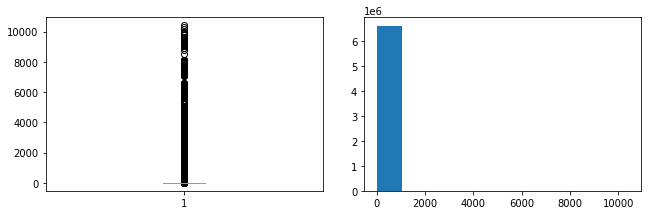

Bot users distribution (normal scale)


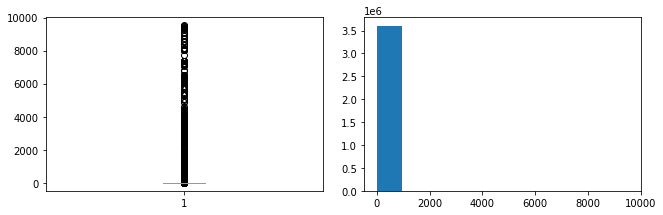

Real users distribution (log scale)


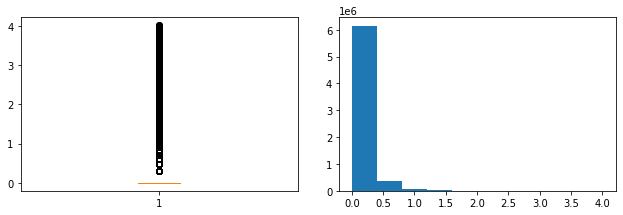

Bot users distribution (log scale)


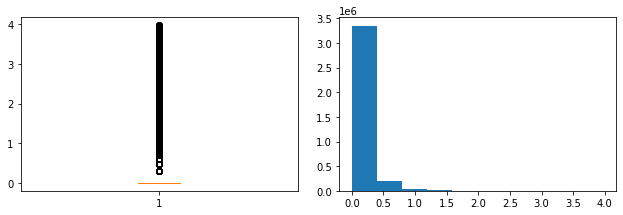

In [ ]:
show_distributions("favorite_count")

### Retweet count

Real users distribution (normal scale)


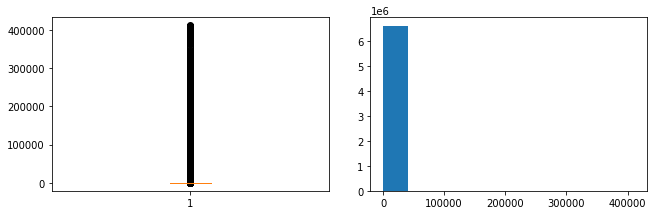

Bot users distribution (normal scale)


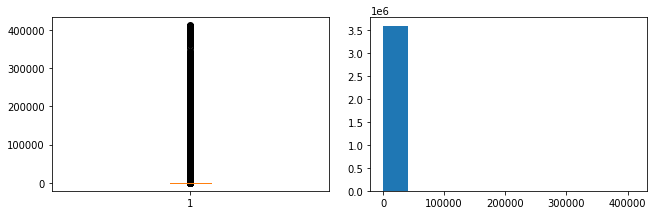

Real users distribution (log scale)


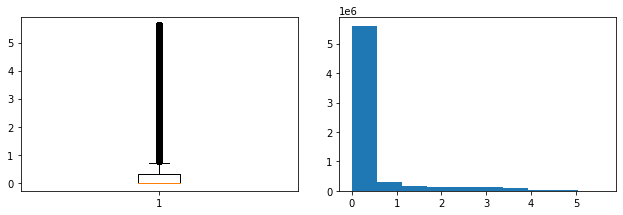

Bot users distribution (log scale)


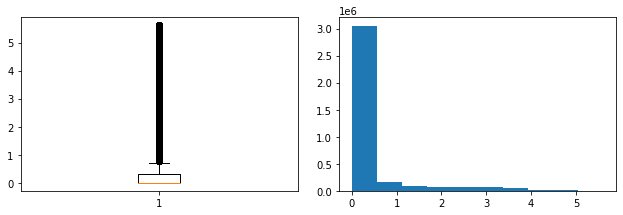

In [ ]:
show_distributions("retweet_count")

### Reply count

Real users distribution (normal scale)


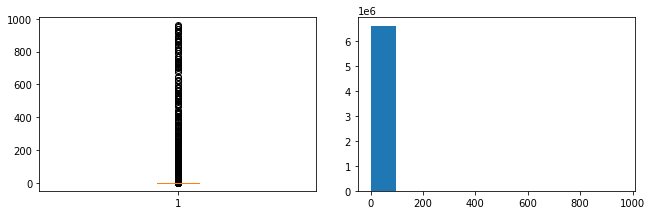

Bot users distribution (normal scale)


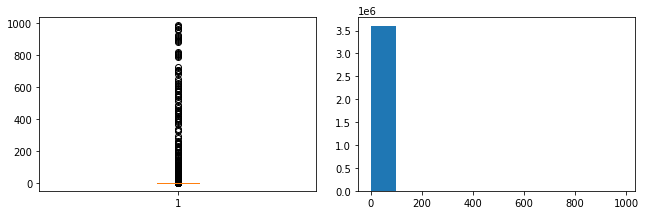

Real users distribution (log scale)


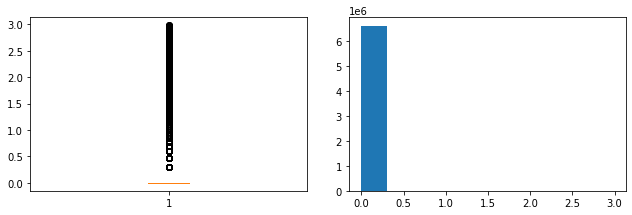

Bot users distribution (log scale)


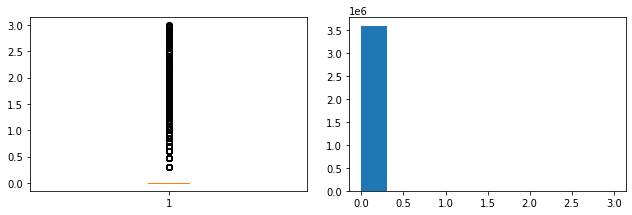

In [ ]:
show_distributions("reply_count")

###  Num urls

Real users distribution (normal scale)


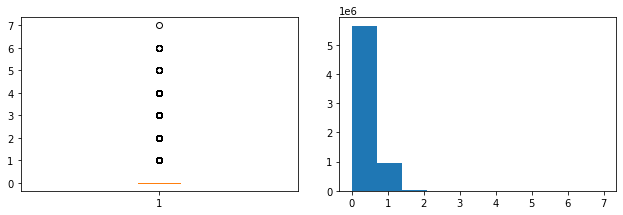

Bot users distribution (normal scale)


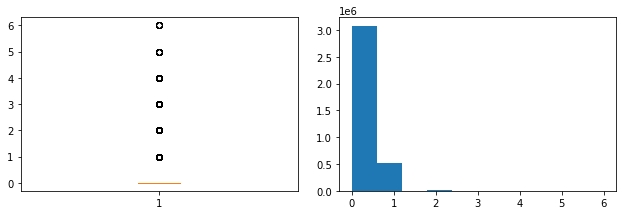

Real users distribution (log scale)


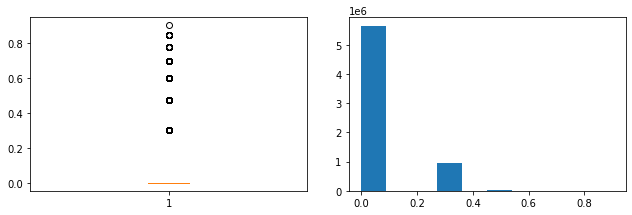

Bot users distribution (log scale)


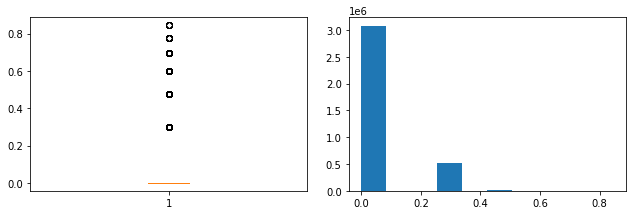

In [ ]:
show_distributions("num_urls")

###  Num mentions

Real users distribution (normal scale)


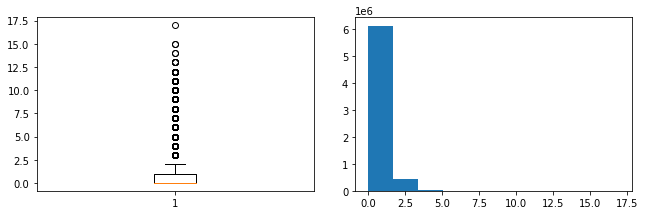

Bot users distribution (normal scale)


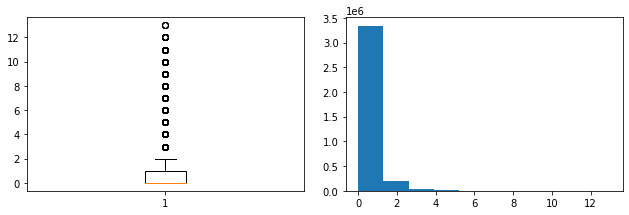

Real users distribution (log scale)


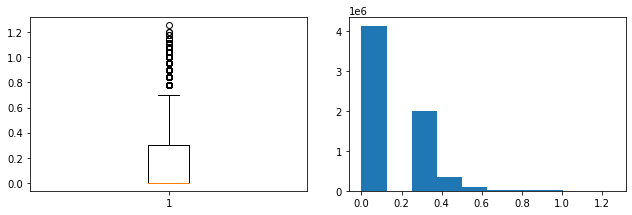

Bot users distribution (log scale)


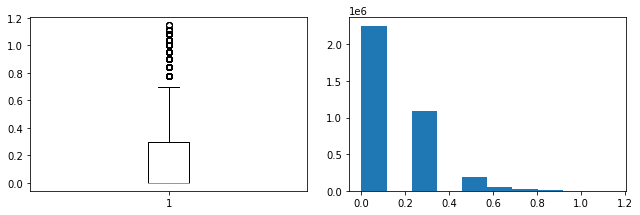

In [ ]:
show_distributions("num_mentions")

### Num hashtags

Real users distribution (normal scale)


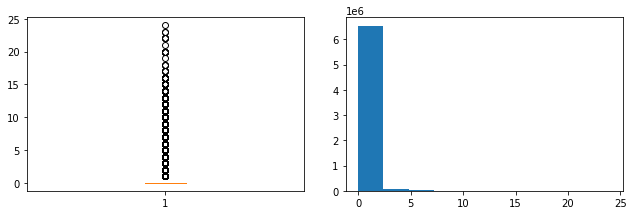

Bot users distribution (normal scale)


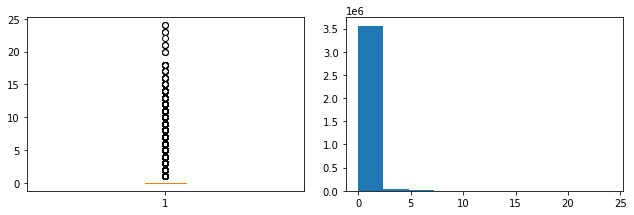

Real users distribution (log scale)


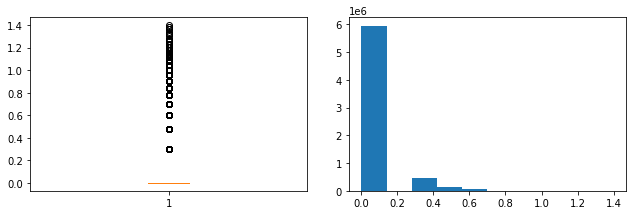

Bot users distribution (log scale)


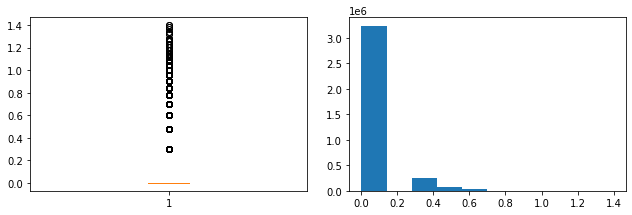

In [ ]:
show_distributions("num_hashtags")